In [2]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GaussianNoise

2024-10-23 10:26:18.432467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 10:26:18.554073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 10:26:18.592622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 10:26:18.819738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 10:26:21.129775: W tensorflow/compiler/tf2

In [3]:
datadir = "data"

X_raw = []
Y = []
X_test_raw = []
Y_test = []

# control
files = os.listdir(os.path.join(datadir, "ctrl"))
files.sort()
for file in files:
    path = os.path.join(datadir, "ctrl", file)
    df = pl.read_csv(path, has_header=False, columns=[0], separator=";")
    X_raw.append(np.reshape(df.to_numpy(), (-1,)))
    Y.append(np.array([1.0, 0.0]))

# positive
files = os.listdir(os.path.join(datadir, "pt"))
files.sort()
for file in files:
    path = os.path.join(datadir, "pt", file)
    df = pl.read_csv(path, has_header=False, columns=[0], separator=";")
    X_raw.append(np.reshape(df.to_numpy(), (-1,)))
    Y.append(np.array([0.0, 1.0]))

# validation
files = os.listdir(os.path.join(datadir, "v"))
files.sort()
for file in files:
    path = os.path.join(datadir, "v", file)
    df = pl.read_csv(path, has_header=False, columns=[0], separator=";")
    X_test_raw.append(np.reshape(df.to_numpy(), (-1,)))
    Y_test.append(np.array([0.0, 1.0]) if 'd' in file else np.array([1.0, 0.0]))

assert len(X_raw) == len(Y)
assert len(X_test_raw) == len(Y_test)
assert len(X_raw[0]) == len(X_test_raw[0])
assert len(Y[0]) == len(Y_test[0])

print("Training samples:", len(X_raw))
print("Testing samples: ", len(X_test_raw))

Training samples: 57
Testing samples:  6


In [4]:
sample_freq = 2000      # Hz
sample_period = 1/2000  # s
signal_length = len(X_raw[0]) * sample_period

[1. 0.]


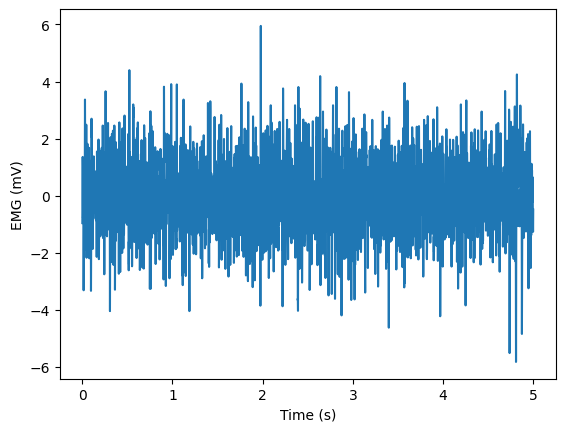

[0. 1.]


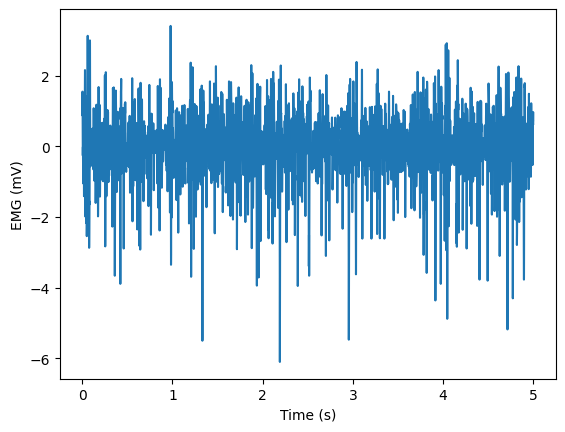

In [5]:
print(Y[0])
plt.plot(np.linspace(0, sample_period * len(X_raw[0]), len(X_raw[0])), 1e3 * X_raw[0])
plt.xlabel("Time (s)")
plt.ylabel("EMG (mV)")
plt.show()

print(Y[-1])
plt.plot(np.linspace(0, sample_period * len(X_raw[-1]), len(X_raw[-1])), 1e3 * X_raw[-1])
plt.xlabel("Time (s)")
plt.ylabel("EMG (mV)")
plt.show()

In [6]:
def to_spectogram(x):
    # Configuration parameters
    nfft = 1024
    noverlap = 512 + 256 + 128
    window = np.hanning(nfft)  # Hanning window function

    # Calculate the step size based on the overlap
    step = nfft - noverlap

    # Pad the signal to handle the windowing properly
    pad_width = (step - (len(X_raw[-1]) - noverlap) % step) % step
    padded_signal = np.pad(X_raw[-1], (0, pad_width), mode='constant')

    # Generate the segments using stride tricks
    segments = np.lib.stride_tricks.sliding_window_view(padded_signal, nfft)[::step]

    # Apply the window function to each segment
    windowed_segments = segments * window

    # Compute the Fourier Transform and get the magnitude squared (power spectrogram)
    Zxx = np.abs(np.fft.rfft(windowed_segments, axis=1))**2

    # Scale to match the matplotlib output
    Sxx = (Zxx / (window.sum()**2)).T

    # Frequencies and time bins
    freqs = np.fft.rfftfreq(nfft, d=1/sample_freq)
    times = np.arange(segments.shape[0]) * step / sample_freq

    return Sxx

In [7]:
X_spec = [to_spectogram(x) for x in X_raw]
X_test_spec = [to_spectogram(x) for x in X_test_raw]

X_spec[0]

array([[8.00816469e-15, 1.11567995e-15, 3.34496271e-15, ...,
        1.19979363e-14, 1.69430478e-17, 1.24307880e-12],
       [4.49030992e-15, 1.10439910e-14, 2.12885784e-15, ...,
        1.22235580e-15, 9.07236458e-15, 1.46725249e-12],
       [5.62329277e-16, 8.35875736e-16, 2.97903018e-15, ...,
        1.35493931e-14, 6.53125191e-15, 1.50112065e-12],
       ...,
       [8.93888581e-15, 9.27637047e-15, 7.67867119e-15, ...,
        1.75599794e-15, 2.40351402e-15, 5.91417831e-15],
       [5.46824805e-15, 7.41877178e-15, 5.33600151e-15, ...,
        5.93353444e-16, 2.05424017e-15, 3.32667618e-15],
       [2.81087329e-15, 3.70386965e-15, 2.28750330e-15, ...,
        5.03442672e-16, 1.51207685e-15, 1.39325230e-14]])

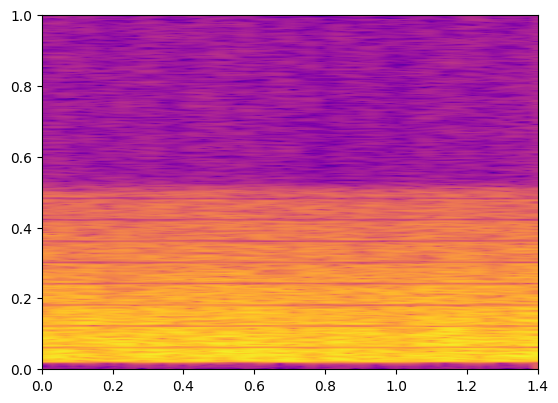

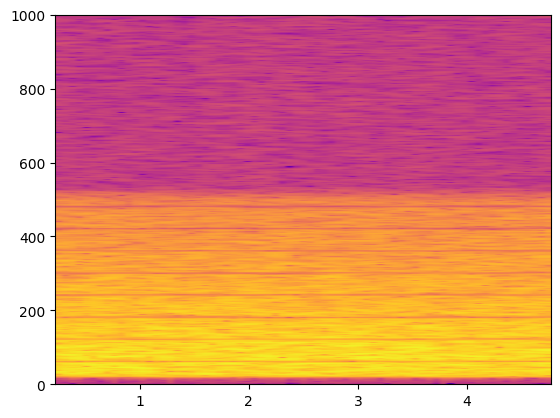

In [8]:
# Reshape the data to add the channel dimension (batch_size, height, width, channels)
X = np.log(np.array(X_spec).reshape(-1, 513, 72, 1))
Y = np.array(Y)
X_test = np.log(np.array(X_test_spec).reshape(-1, 513, 72, 1))
Y_test = np.array(Y_test)

plt.imshow(X[5,:,:,0], cmap='plasma', interpolation='bilinear', origin='lower', extent=[0, 1.4, 0, 1])
plt.show()

plt.specgram(X_raw[5], NFFT=1024, Fs=sample_freq, noverlap=1024-128, cmap='plasma')
plt.show()

The image above was generated as a comparison reference, to ensure the reshape is working as expected

In [9]:
""" # Define the CNN model
model = Sequential([
    Input((513, 72, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='gelu'),
    Dense(64, activation='gelu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, Y, epochs=50, batch_size=64, validation_data=(X_test, Y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict the probabilities for the test set
predictions = model.predict(X_test)
print(predictions)
 """

' # Define the CNN model\nmodel = Sequential([\n    Input((513, 72, 1)),\n    Conv2D(32, kernel_size=(3, 3), activation=\'relu\'),\n    MaxPooling2D(pool_size=(2, 2)),\n    Conv2D(64, kernel_size=(3, 3), activation=\'relu\'),\n    MaxPooling2D(pool_size=(2, 2)),\n    Flatten(),\n    Dense(128, activation=\'gelu\'),\n    Dense(64, activation=\'gelu\'),\n    Dropout(0.5),\n    Dense(2, activation=\'softmax\')  # Output layer with softmax for probability output\n])\n\n# Compile the model\nmodel.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])\n\n# Train the model\nmodel.fit(X, Y, epochs=50, batch_size=64, validation_data=(X_test, Y_test))\n\n# Evaluate the model\nloss, accuracy = model.evaluate(X_test, Y_test)\nprint(f"Test Accuracy: {accuracy * 100:.2f}%")\n\n# Predict the probabilities for the test set\npredictions = model.predict(X_test)\nprint(predictions)\n '

We started by trying to analyse the signal by pre-processing with a spectogram. This proved ineffective due to how the actual feature we want to analyze is the signal decay on people with the condition, and a spectrogram discards this type of information.

In [10]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [23]:
X_amp = np.array([moving_average(x, 20) for x in X_raw])
X_test_amp = np.array([moving_average(x, 20) for x in X_test_raw])

X_amp.shape

(57, 9982)

In [12]:
sample_count = len(X_amp[0])
X = np.array(X_amp).reshape(-1, sample_count)
Y = np.array(Y)
X_test = np.array(X_test_amp).reshape(-1, sample_count)
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)

((57, 9982), (57, 2), (6, 9982), (6, 2))

In [13]:
# Define the CNN model
model = Sequential([
    Input((sample_count,)),
    Dropout(0.99),
    GaussianNoise(1e-5),
    # Dense(1, activation='gelu'),
    # Dense(2, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['binary_accuracy', 'Precision', 'F1Score', 'Recall'])
model.fit(X, Y, epochs=100, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy, prec, f1, recall = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
print(f"Train Precision: {prec}")
print(f"Train Recall: {recall}")
print(f"Train F1Score: {f1}")
loss, accuracy, prec, f1, recall = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {prec}")
print(f"Test Recall: {recall}")
print(f"Test F1Score: {f1}")


I0000 00:00:1729689986.637676     732 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729689986.873325     732 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729689986.873519     732 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729689986.880870     732 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729689986.881001     732 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/100


I0000 00:00:1729689991.609477    1070 service.cc:146] XLA service 0x7f38a8009ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729689991.609544    1070 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-10-23 10:26:31.694665: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 10:26:31.916436: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1729689995.629685    1070 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 - 12s - 3s/step - F1Score: 0.4182 - Precision: 0.4211 - Recall: 0.4211 - binary_accuracy: 0.4211 - loss: 0.6926 - val_F1Score: 0.3333 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_binary_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/100
4/4 - 0s - 34ms/step - F1Score: 0.6311 - Precision: 0.6316 - Recall: 0.6316 - binary_accuracy: 0.6316 - loss: 0.6915 - val_F1Score: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_binary_accuracy: 1.0000 - val_loss: 0.6923
Epoch 3/100
4/4 - 0s - 33ms/step - F1Score: 0.4751 - Precision: 0.4912 - Recall: 0.4912 - binary_accuracy: 0.4912 - loss: 0.6936 - val_F1Score: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_binary_accuracy: 1.0000 - val_loss: 0.6919
Epoch 4/100
4/4 - 0s - 34ms/step - F1Score: 0.6275 - Precision: 0.6316 - Recall: 0.6316 - binary_accuracy: 0.6316 - loss: 0.6913 - val_F1Score: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_binary_accuracy: 1.0000 - val_loss: 0.6914
Epoch 5/100
4/4 - 0s - 33ms/step 

In [14]:
# Extract features with PCA because 9982 is too many
from sklearn.decomposition import PCA

n_components = 8
pca = PCA(n_components=n_components)

X_amp_pca = pca.fit_transform(X_amp)
X_test_amp_pca = pca.transform(X_test_amp)

X_amp_pca.shape

(57, 8)

In [15]:
X = X_amp_pca
Y = np.array(Y)
X_test = X_test_amp_pca
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)

((57, 8), (57, 2), (6, 8), (6, 2))

In [16]:
# Define the CNN model
model = Sequential([
    Input((n_components,)),
    Dropout(0.2),
    GaussianNoise(1e-5),
    Dense(4, activation='gelu'),
    # Dense(3, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=600, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/600
4/4 - 7s - 2s/step - binary_accuracy: 0.6667 - loss: 0.6918 - val_binary_accuracy: 0.6667 - val_loss: 0.6923
Epoch 2/600
4/4 - 0s - 21ms/step - binary_accuracy: 0.5789 - loss: 0.6918 - val_binary_accuracy: 0.6667 - val_loss: 0.6922
Epoch 3/600
4/4 - 0s - 24ms/step - binary_accuracy: 0.6140 - loss: 0.6913 - val_binary_accuracy: 0.6667 - val_loss: 0.6922
Epoch 4/600
4/4 - 0s - 24ms/step - binary_accuracy: 0.5614 - loss: 0.6913 - val_binary_accuracy: 0.6667 - val_loss: 0.6921
Epoch 5/600
4/4 - 0s - 23ms/step - binary_accuracy: 0.5263 - loss: 0.6920 - val_binary_accuracy: 0.5000 - val_loss: 0.6920
Epoch 6/600
4/4 - 0s - 23ms/step - binary_accuracy: 0.5965 - loss: 0.6913 - val_binary_accuracy: 0.5000 - val_loss: 0.6919
Epoch 7/600
4/4 - 0s - 22ms/step - binary_accuracy: 0.5965 - loss: 0.6911 - val_binary_accuracy: 0.5000 - val_loss: 0.6919
Epoch 8/600
4/4 - 0s - 24ms/step - binary_accuracy: 0.6316 - loss: 0.6909 - val_binary_accuracy: 0.5000 - val_loss: 0.6918
Epoch 9/600
4/4 - 

|Layers|Loss|Accuracy|
|------|----|--------|
|4     |0.55|100%    |
|4,4   |0.20|100%    |
|6,2   |0.26|100%    |
|8     |0.42|100%    |

In [17]:
print(model.predict(X_test))
Y_test[:,1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
[[0.39206937 0.60793066]
 [0.0401571  0.95984286]
 [0.26638523 0.7336148 ]
 [0.7144094  0.28559065]
 [0.81060475 0.18939531]
 [0.8359194  0.16408068]]


array([1., 1., 1., 0., 0., 0.])

In [18]:
Y[0,:]

array([1., 0.])

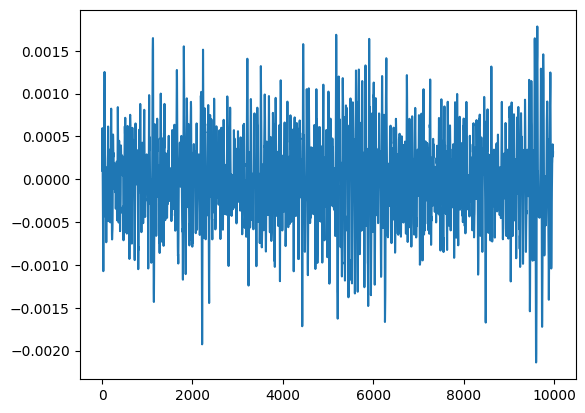

In [21]:
plt.plot(X_amp[1,:])

In [39]:
X_samp = np.array([moving_average(x**2, 20) for x in X_raw])
X_test_samp = np.array([moving_average(x**2, 20) for x in X_test_raw])

X_samp.shape

(57, 9982)

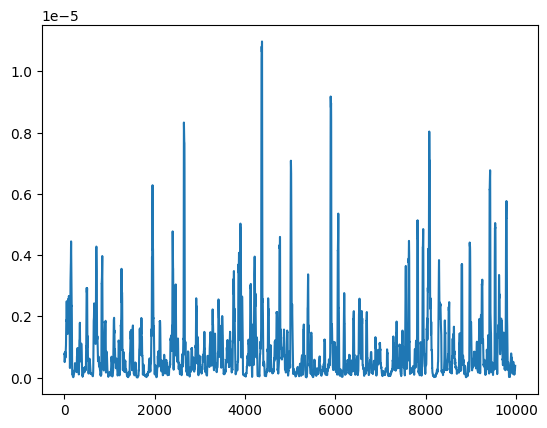

In [40]:
plt.plot(X_samp[-1,:])

In [46]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)

X_samp_pca = pca.fit_transform(X_samp)
X_test_samp_pca = pca.transform(X_test_samp)

X_samp_pca.shape

(57, 10)

In [47]:
X = X_samp_pca
Y = np.array(Y)
X_test = X_test_samp_pca
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)

((57, 10), (57, 2), (6, 10), (6, 2))

In [48]:
# Define the CNN model
model = Sequential([
    Input((n_components,)),
    # Dropout(0.2),
    # GaussianNoise(1e-5),
    Dense(4, activation='gelu'),
    # Dense(3, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=400, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/400
4/4 - 4s - 1s/step - binary_accuracy: 0.4912 - loss: 0.6932 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/400
4/4 - 0s - 23ms/step - binary_accuracy: 0.5263 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/400
4/4 - 0s - 22ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/400
4/4 - 0s - 20ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/400
4/4 - 0s - 22ms/step - binary_accuracy: 0.5263 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/400
4/4 - 0s - 21ms/step - binary_accuracy: 0.5263 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/400
4/4 - 0s - 20ms/step - binary_accuracy: 0.5263 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/400
4/4 - 0s - 21ms/step - binary_accuracy: 0.5263 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 9/400
4/4 - 